## External coupling estimation

In [5]:
import mypy as mp
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy.signal import find_peaks

data_path_wide = '/home/lesnow/PalaceForCQED/examples/data_v8/driven/lumped_7.0-7.8_Step0.001_2025-04-03T024135/port-S.csv'
data_path_small = '/home/lesnow/PalaceForCQED/examples/data_v8/driven/lumped_7.168-7.217_Step0.0002_2025-04-03T095242/port-S.csv'
# small_scan_center_idx = 192 # None
# small_scan_range = 100

In [6]:
def normalize_y_01(y):
    min_y, max_y = np.min(y), np.max(y)
    return (y-min_y)/(max_y-min_y), min_y, max_y

def renormalize_y(y, min_y, max_y):
    return y*(max_y-min_y)+min_y


import matplotlib as mpl
params = {
    'figure.dpi': 300,
    'savefig.dpi': 300, 
    'svg.fonttype': 'none',
    'pdf.fonttype': 42,
    # 'font.family': 'Arial', 
    'font.size': 6,
    'axes.linewidth' : 0.75,         
    'xtick.major.size':2,
    'ytick.major.size':2,    
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'xtick.major.pad': 4,
    'ytick.major.pad': 2,              
    'xtick.labelsize' : 6,
    'ytick.labelsize' : 6,
    'xtick.major.width': 0.75,
    'ytick.major.width': 0.75,
    'xtick.bottom': True,
    'xtick.top': True,
    'ytick.left': True,
    'ytick.right': True,         
    'lines.linewidth': 0.75,  
    'lines.markersize': 2.5,           
    'lines.markeredgewidth': 0.0,
    'legend.frameon': True,
    'legend.numpoints': 1,
    'legend.loc': 'best',
    'legend.fontsize': 6,
    'axes.grid': False,
}
mpl.rcParams.update(params)

## Wide Scan

Achieved in 1 iterations.
0: 7.168 ~ 7.217
1: 7.261 ~ 7.31
2: 7.535 ~ 7.584
3: 7.63 ~ 7.679
We found 4 peaks.


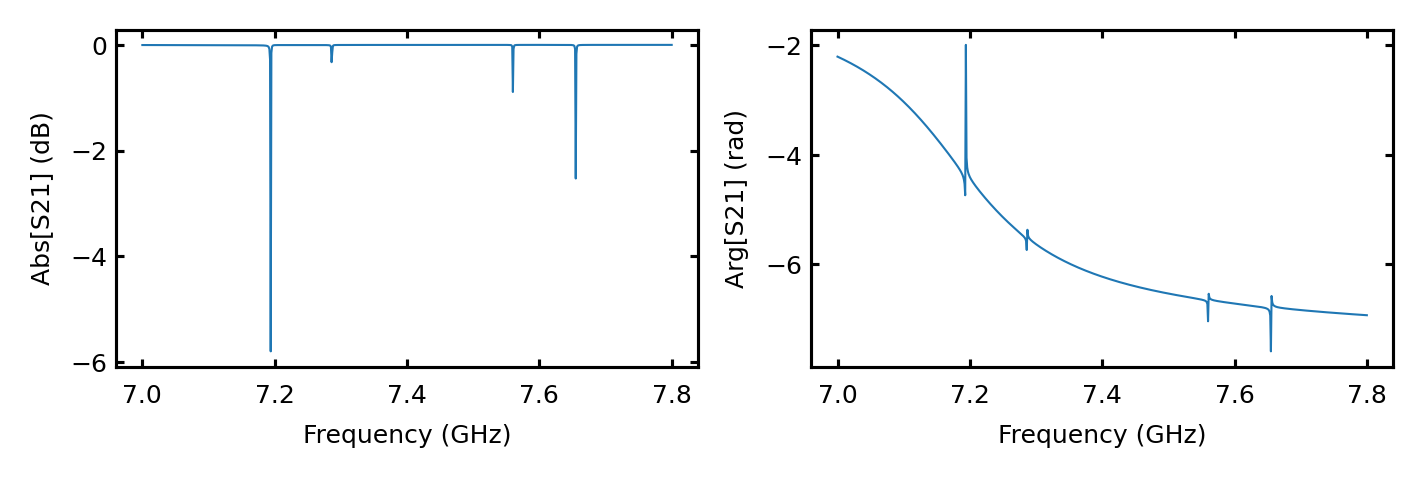

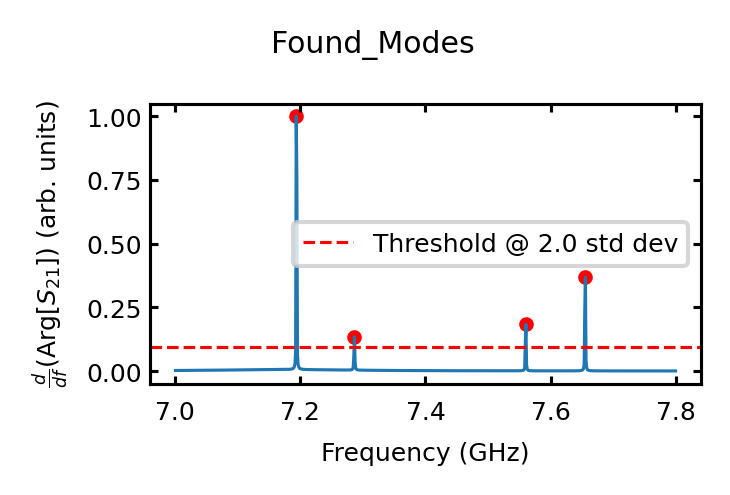

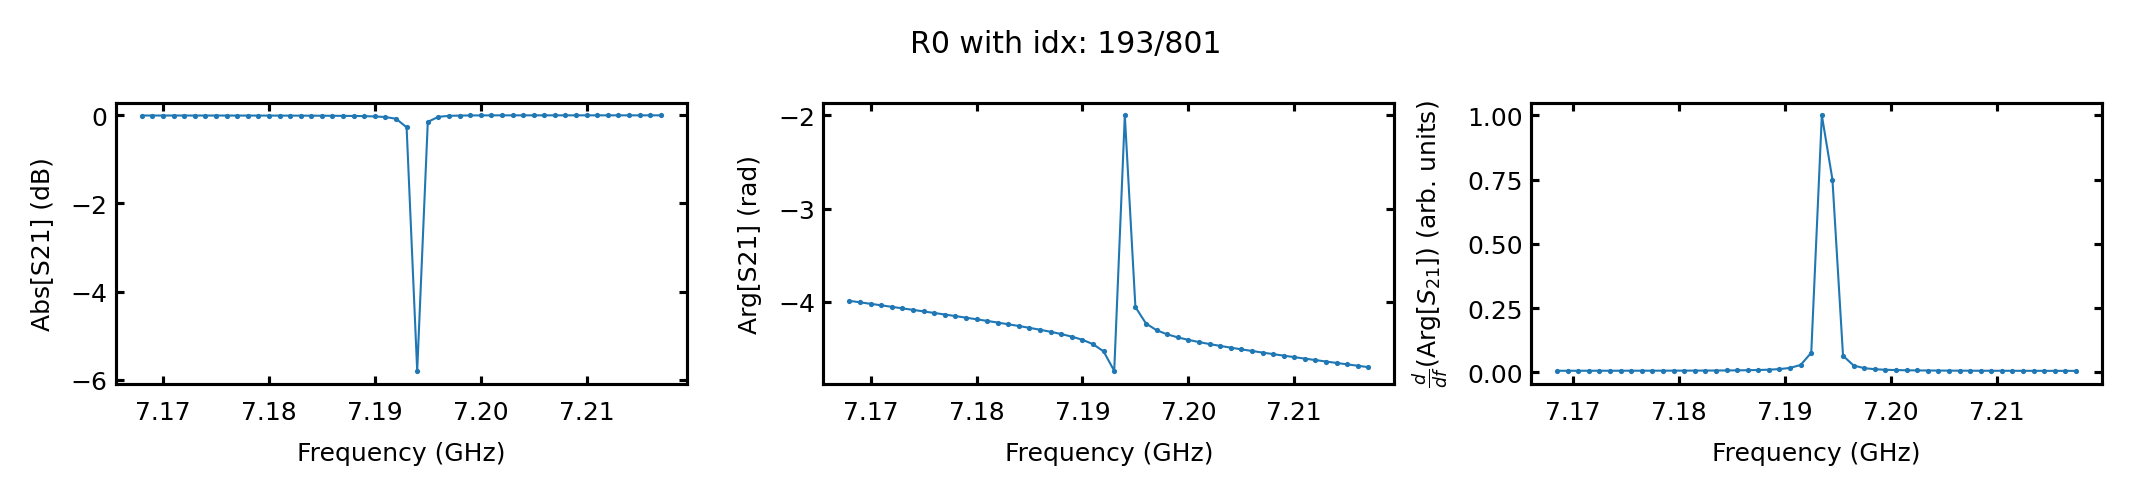

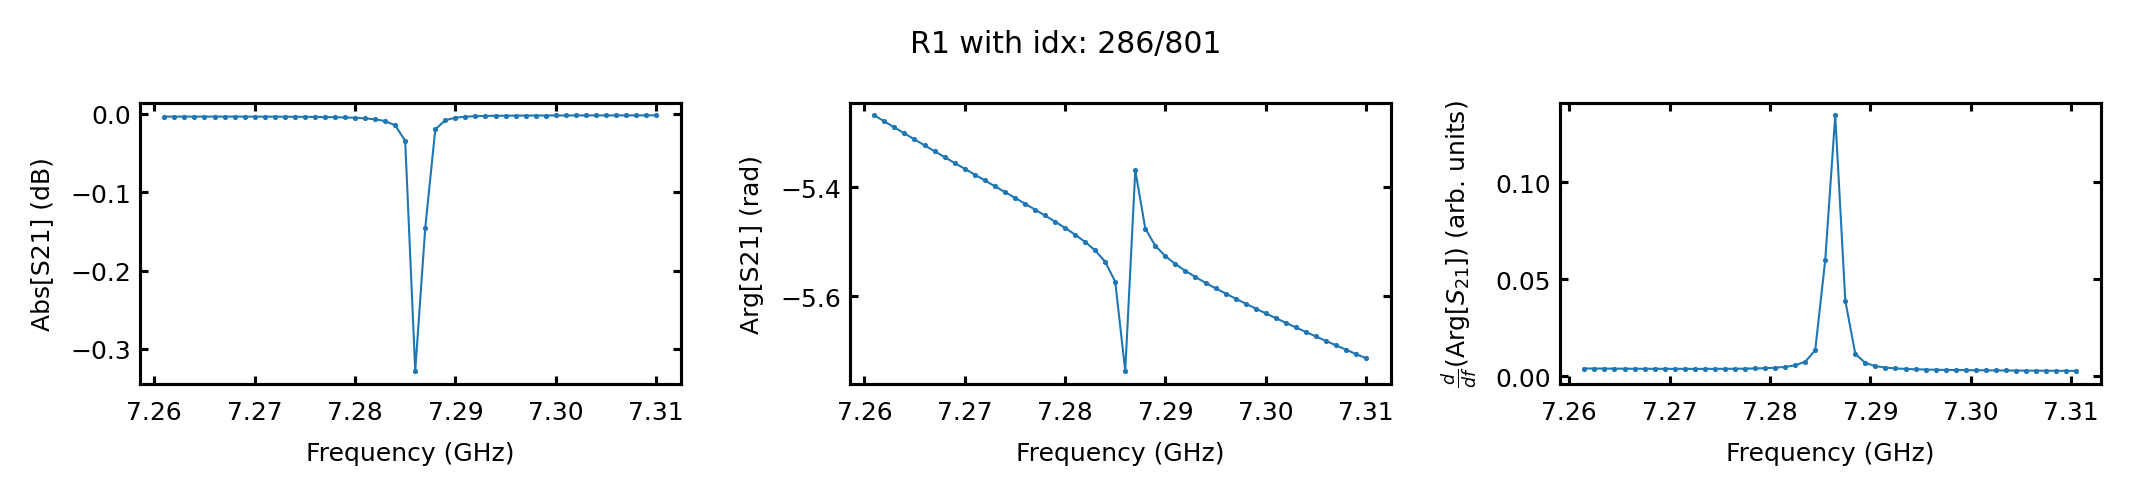

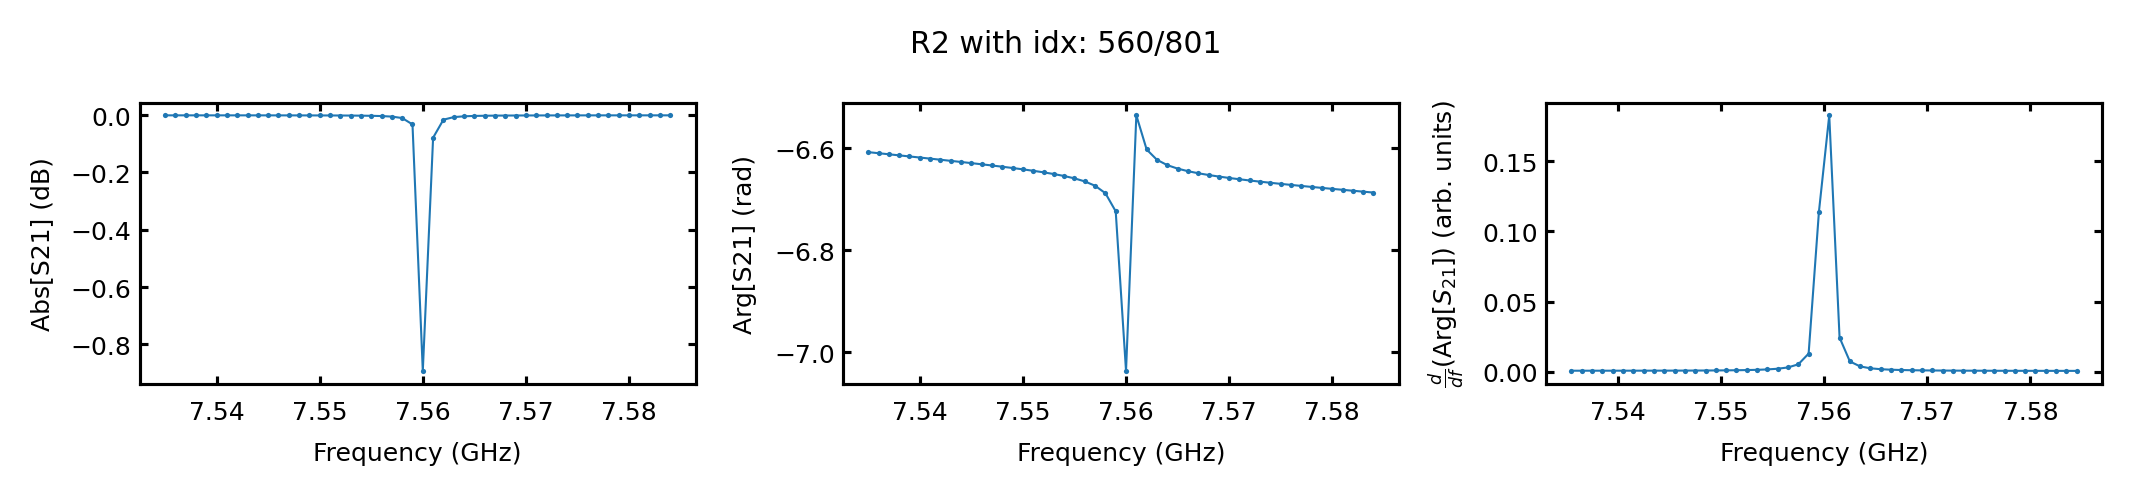

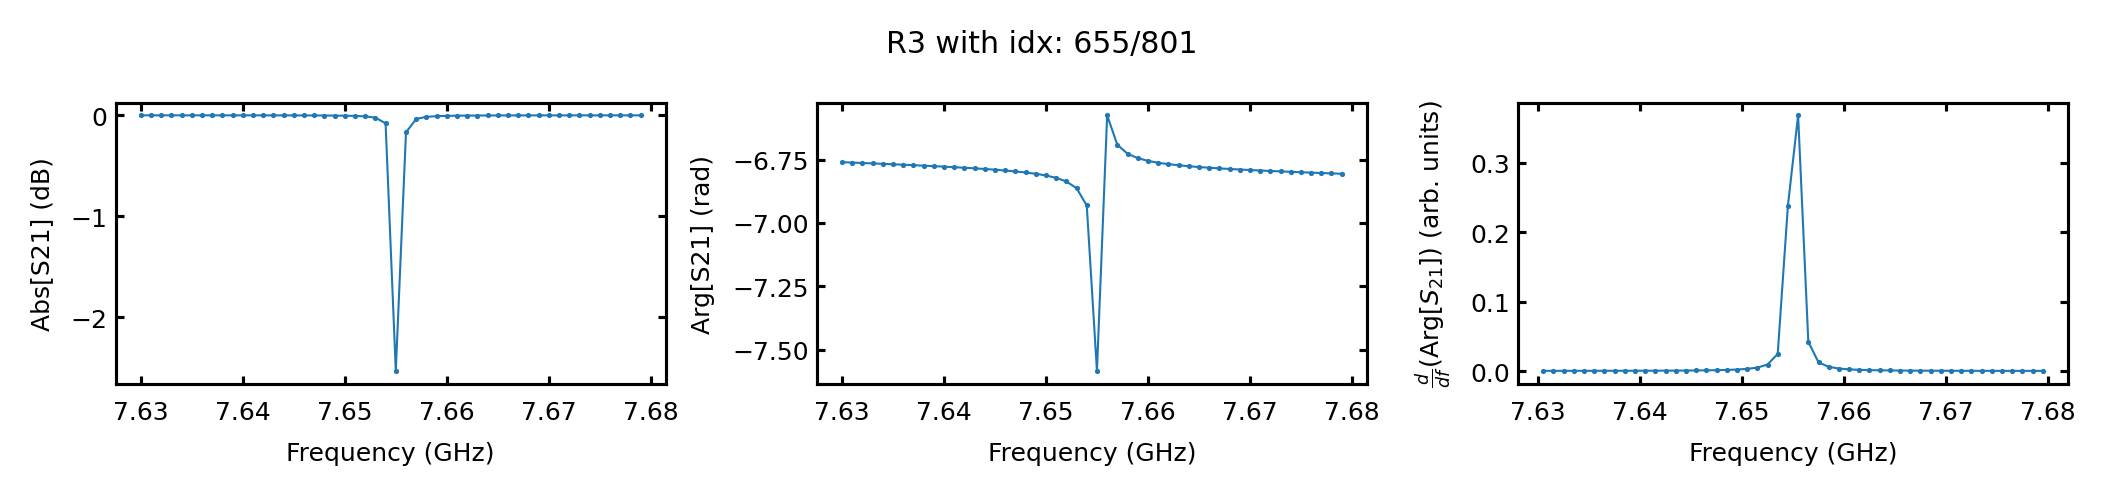

In [7]:
use_phase_derivative = True # True

n_peaks = 4
smoothing_interpolation = 15
nbr_std_dev = 2
max_nbr_iter = 500
magnify_span = 0.5e8


# load data from CSC file (freq, phase, amp)
with open(data_path_wide, 'r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    data = []
    cnt = 0 
    for row in plots:
        if cnt > 0:
            data.append(row)
        cnt += 1

freqs = np.array([float(row[0]) for row in data]) * 1e9
# z_real = np.array([float(row[1]) for row in data])
# z_imag = np.array([float(row[2]) for row in data] )
# z = z_real + 1j*z_imag

# amp = np.abs(z)
# pha = np.unwrap(np.angle(z))

amp = 10**(np.array([float(row[1]) for row in data]) / 20)
pha = np.unwrap(np.deg2rad(np.array([float(row[2]) for row in data])))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*6/2.54, 4/2.54))
ax = axes[0]
ax.plot(freqs/1e9, 20*np.log10(amp), '-', lw=0.5, label='')
ax.set_xlabel('Frequency (GHz)')          
ax.set_ylabel('Abs[S21] (dB)')
ax = axes[1]
ax.plot(freqs/1e9, pha, '-', lw=0.5, label='')
ax.set_xlabel('Frequency (GHz)')          
ax.set_ylabel('Arg[S21] (rad)')
fig.tight_layout()

if use_phase_derivative:
    phase_derivative = np.abs(np.diff(pha) / np.diff(freqs))

    normalized_spectrum = phase_derivative / np.max(phase_derivative)

    freqs_plot = (freqs[1:] + freqs[:-1]) / 2.0
else:
    s_re = np.real(z)
    s_im = np.imag(z)

    s_re, min_sr, max_sr = normalize_y_01(s_re)
    s_im, min_si, max_si = normalize_y_01(s_im)

    bkg_re = renormalize_y(splev(freqs, splrep(freqs, s_re, s=smoothing_interpolation), der=0), min_sr, max_sr)
    bkg_im = renormalize_y(splev(freqs, splrep(freqs, s_im, s=smoothing_interpolation), der=0), min_si, max_si)
    bkg_z = bkg_re + 1j * bkg_im

    fig.tight_layout()

    normalized_spectrum = 20*np.abs(np.log10(np.abs(z/bkg_z)))
    normalized_spectrum /= np.max(normalized_spectrum)

    freqs_plot = freqs

spectrum_std = normalized_spectrum.std()
height_threshold = nbr_std_dev * spectrum_std
peaks_found = 0
i = 0
while peaks_found != n_peaks and i < max_nbr_iter:
    idx_peaks, _ = find_peaks(normalized_spectrum, height=height_threshold)
    peaks_found = len(idx_peaks)
    if peaks_found > n_peaks:
        height_threshold *= 1.02
    elif peaks_found > n_peaks:
        height_threshold *= 0.98
    i += 1
print(f"Achieved in {i} iterations.")

resonant_freqs = np.array([freqs[idx_peak] for idx_peak in idx_peaks])
resonances = {
    f"R{i}": {
        "idx": idx_peak, 
        "freq": freqs[idx_peak],
        "popt": None,
        "k_in+k_ex": 0,
        "single_photon_power": 0,
        "single_photon_power@VNA": 0,
        "Q": [],
        "Q_SNR": 0,
        "Q_err": [],
        "Q_err_SNR": 0,
        "w_r": [],
        "w_r_SNR": 0,
        "w_r_err": [],
        "w_r_err_SNR": 0,
        "photon_nbrs_dB": [],
        "photon_nbrs_dB_SNR": 0,
    } for i, idx_peak in enumerate(idx_peaks)
}

fig, ax = plt.subplots(figsize=(6/2.54, 4/2.54))
fig.suptitle("Found_Modes")
ax.plot(freqs_plot / 1e9, normalized_spectrum)
ax.axhline(height_threshold, linestyle="--", color="r", label=f"Threshold @ {np.round(height_threshold / spectrum_std, 2)} std dev")
ax.scatter(resonant_freqs / 1e9, [normalized_spectrum[idx_peak] for idx_peak in idx_peaks], color="r")
ax.set_xlabel('Frequency (GHz)')
if use_phase_derivative:
    ax.set_ylabel(r'$\frac{d}{df}$(Arg[$S_{21}$]) (arb. units)')
else:
    ax.set_ylabel('|$S_{21}$| (arb. units)')
ax.legend()
fig.tight_layout()


for j, idx_peak in enumerate(idx_peaks):
    max_freq = np.max(freqs)
    min_freq = np.min(freqs)
    npts = len(freqs)
    span = max_freq - min_freq

    npts_magnify = int(npts * magnify_span / span)
    freqs_magnify = freqs[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)]/1e9
    print(f"{j}: {np.min(freqs_magnify)} ~ {np.max(freqs_magnify)}")

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3*6/2.54, 4/2.54))
    fig.suptitle("R" + str(j) + " with idx: "+str(idx_peak) + "/" + str(len(freqs)))
    ax = axes[0]
    ax.plot(freqs_magnify, 20*np.log10(amp[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)]), '.-', lw=0.5, label='')
    ax.set_xlabel('Frequency (GHz)')          
    ax.set_ylabel('Abs[S21] (dB)')
    ax = axes[1]
    ax.plot(freqs_magnify, pha[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)], '.-', lw=0.5, label='')
    ax.set_xlabel('Frequency (GHz)')          
    ax.set_ylabel('Arg[S21] (rad)')
    ax = axes[2]
    ax.plot(freqs_plot[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)]/1e9, normalized_spectrum[int(idx_peak-npts_magnify/2):int(idx_peak+npts_magnify/2)], '.-', lw=0.5, label='')
    ax.set_xlabel('Frequency (GHz)')          
    ax.set_ylabel(r'$\frac{d}{df}$(Arg[$S_{21}$]) (arb. units)')
    fig.tight_layout()

print("We found", len(idx_peaks), "peaks.")

## Small Scan

w_r/2pi  = 7.1932701 +/- 1e-06 GHz
k_ex/2pi = 0.359 +/- 0.001 MHz
k_in/2pi = 0.134 +/- 0.001 MHz
Q = 0.05 +/- 0.0 M
SNR = 533.8360738538387


ValueError: x and y must have same first dimension, but have shapes (246,) and (1,)

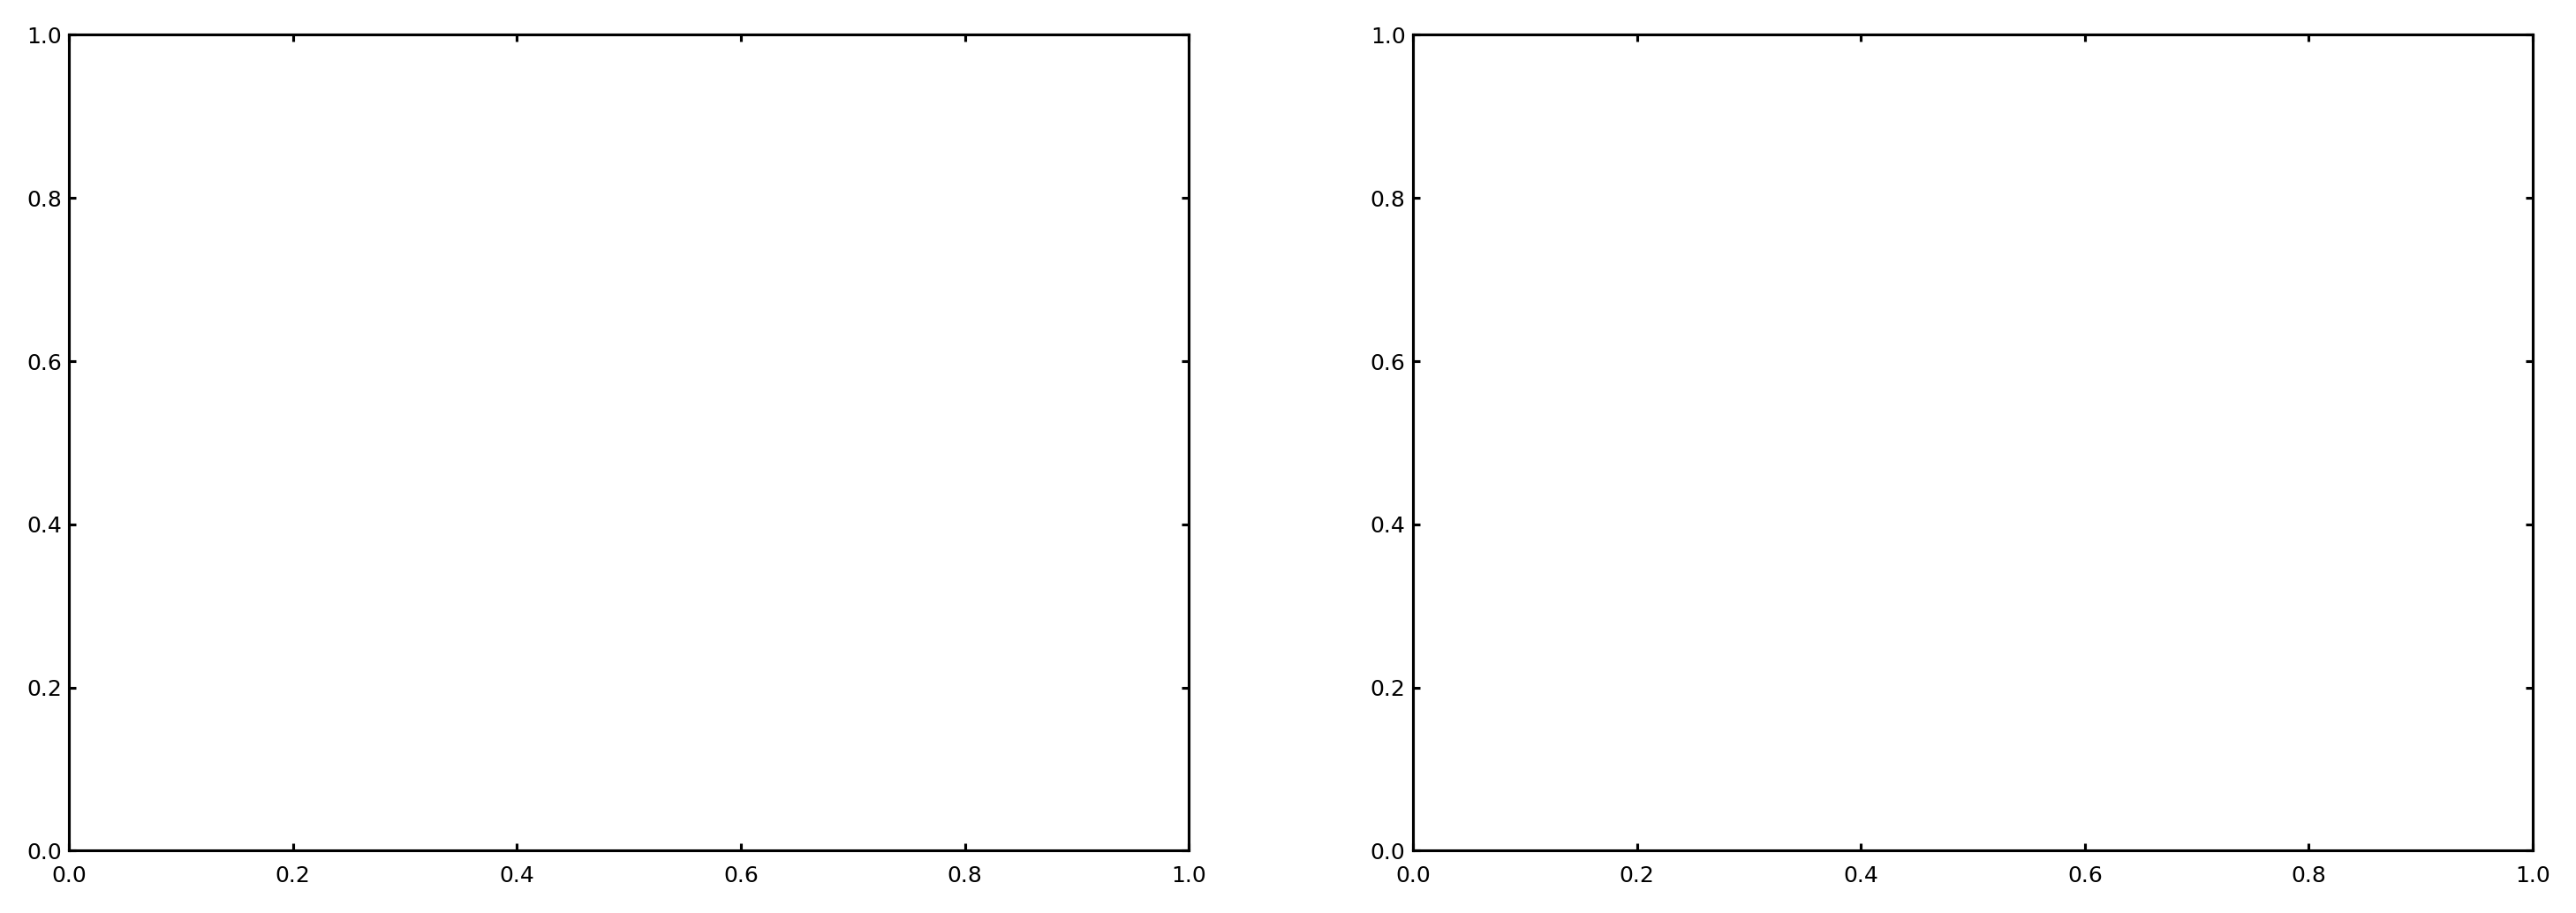

In [8]:
# first check if everything is nicely fitted, then update the dictionary
# modify_dict = False
use_no_fano_with_amp = True

# load data from CSC file (freq, phase, amp)
with open(data_path_small, 'r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    data = []
    cnt = 0 
    for row in plots:
        if cnt > 0:
            data.append(row)
        cnt += 1

# freqs = np.array([float(row[0]) for row in data])
# z_real = np.array([float(row[1]) for row in data])
# z_imag = np.array([float(row[2]) for row in data])
# z = z_real + 1j*z_imag
# z = [z]

# amps, phases = np.abs(z), np.unwrap(np.angle(z))

freqs = np.array([float(row[0]) for row in data]) * 1e9
amps = 10**(np.array([float(row[1]) for row in data]) / 20)
phases = np.unwrap(np.deg2rad(np.array([float(row[2]) for row in data])))
z = amps * np.exp(1j * phases)
z = [z]

avg = 1
z_avg = np.average(z, axis=0)
amps_avg, phases_avg = np.abs(z_avg), np.unwrap(np.angle(z_avg))
avg_phase = np.mean(phases_avg)
phases -= avg_phase
phases_avg -= avg_phase



if use_no_fano_with_amp:
    try:
        popt, perr, zfit, zini = mp.S11exp_fit_no_fano_with_amp(freqs, amps_avg, phases_avg)
        amp_normalisation = popt[-1]
    except:
        amp_normalisation = 1
        pass
else:
    popt, perr, zfit, zini = mp.Lorentzian_fit(freqs, amps_avg ** 2, ini=False)
    offset_amps = np.sqrt(popt[3])

    # offset_amps = mp.get_offset(amps_avg)
    amps /= offset_amps
    amps_avg /= offset_amps

    amp_normalisation = 1
    try:
        # f0,kex,kin,phi,tau,x0,y0
        popt, perr, zfit, zini = mp.S11exp_fit(freqs, amps_avg, phases_avg)
    except:
        pass


try:
    poptc, perrc = mp.popt_correct(popt, perr, print_on=False)

    amf = np.absolute(zfit)
    phf = np.angle(zfit)
    phf = np.unwrap(phf)
    phf -= np.floor((np.average(phf)+np.pi)/(2*np.pi))*2*np.pi

    ami = np.absolute(zini)
    phi = np.angle(zini)
    phi = np.unwrap(phi)
    phi -= np.floor((np.average(phi)+np.pi)/(2*np.pi))*2*np.pi
    
    w_r = poptc[0]
    k_ex = poptc[1]
    k_in = poptc[2]
    # P_1 = single_photon_power(w_r, k_in, k_ex, frequency_units=True)
    # P_1_dBm = 10*np.log10(P_1/1e-3)
    print('w_r/2pi  =', w_r/1e9, '+/-', perrc[0]/1e9, 'GHz')
    print('k_ex/2pi =', k_ex/1e6, '+/-', perrc[1]/1e6, 'MHz')
    print('k_in/2pi =', k_in/1e6, '+/-', perrc[2]/1e6, 'MHz')
    std_dev_power = w_r/k_in*np.sqrt((perrc[0]/w_r)**2+(perrc[2]/k_in)**2)
    print('Q =', round(w_r/k_in/1e6, 2), '+/-', round(std_dev_power/1e6, 2), 'M')
    # print('Single photon power =', round(P_1_dBm, 1), 'dBm')
    # print('Single photon power @ VNA =', round(P_1_dBm-tot_attenuation, 1), 'dBm')
    print('SNR =', (np.mean(amps_avg) / np.std(amps_avg))**2)
    
    # if modify_dict:
    #     resonance["avg_phase"] = avg_phase
    #     resonance["popt"] = popt
    #     resonance["freq"] = w_r
    #     resonance["k_in+k_ex"] = k_in + k_ex
    #     resonance["single_photon_power"] = round(P_1_dBm, 1)
    #     resonance["single_photon_power@VNA"] = round(P_1_dBm-tot_attenuation, 1)
except:
    pass
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
# fig.suptitle("R" + str(j) + " with id: " + str(dataset.captured_run_id))

ax = axes[0]
for i in range(avg):
    ax.plot(freqs/1e9, amps[i]/amp_normalisation, '-', lw=0.25, alpha=0.25)
ax.plot(freqs/1e9, amps_avg/amp_normalisation, 'b.', lw=0.5)
try:
    ax.plot(freqs/1e9, ami/amp_normalisation, 'g-', lw=0.5,alpha=0.5)
    ax.plot(freqs/1e9, amf/amp_normalisation, 'r-', lw=0.5)
except:
    pass
ax.set_xlabel('Frequency (GHz)')          
ax.set_ylabel(r'abs[$S_{21}$]')
ax.set_ylim(0, 1.1*np.max(amps)/amp_normalisation)

ax = axes[1]
for i in range(avg):
    ax.plot(freqs/1e9, phases[i], '-', lw=0.25, alpha=0.25)
ax.plot(freqs/1e9, phases_avg, 'b.', lw=0.5)
try:
    ax.plot(freqs/1e9, phi, 'g-', lw=0.5,alpha=0.5)
    ax.plot(freqs/1e9, phf, 'r-', lw=0.5)
except:
    pass
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel(r'arg[$S_{21}$] (rad)')
fig.tight_layout()
plt.show()